In [1]:
# Import packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Load data
df_website = pd.read_excel("../2_Pre_Analysis/Output_after_pre_analysis.xlsx")
df_google_aff = pd.read_excel("../4_Similarity/cleaned_google_affinity.xlsx")

In [3]:
df_website.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16741 entries, 0 to 16740
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Userprofile_url           16741 non-null  object
 1   Username                  16741 non-null  object
 2   Reviewdate                16741 non-null  object
 3   Productname               16741 non-null  object
 4   review_title              16741 non-null  object
 5   review_text               16741 non-null  object
 6   categoryfirst_breadcrumb  16737 non-null  object
 7   allbreadcrumbs            16725 non-null  object
 8   price                     16741 non-null  object
 9   urlproduct                16741 non-null  object
 10  verified_review           16741 non-null  object
 11  Feedback                  16741 non-null  object
dtypes: object(12)
memory usage: 1.5+ MB


In [4]:
df_google_aff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Cleaned Categories2  154 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


In [5]:
# Read the product categories from Amazon Excel file
categories_website = df_website['categoryfirst_breadcrumb'].tolist()

# print(categories_website1)

In [6]:
# Prepossed categories from Amazon Excel File
def clean_category(category):
    if category == 0:
        return category  # Skip preprocessing for category equal to 0
    
    if isinstance(category, int):
        return category  # Skip preprocessing for int category
        
    if isinstance(category, float):
        return category  # Skip preprocessing for float category
    
    if not category.strip():  # Check if category is blank or empty
        return category  # Skip preprocessing for blank category
    
# for category in categories_website:
    # Remove HTML tags and special characters using BeautifulSoup
    category_text = BeautifulSoup(str(category), 'html.parser').get_text()
    cleaned_category = re.sub(r'[^\w\s]', '', category_text)
    cleaned_category = cleaned_category.lower()  # Convert to lowercase
    cleaned_category = re.sub(' +', ' ', cleaned_category)  # Replace consecutive spaces
    return cleaned_category

In [7]:
df_website['categoryfirst_breadcrumb'] = df_website['categoryfirst_breadcrumb'].apply(clean_category)
df_website['categoryfirst_breadcrumb'].head()

0                toys games
1                toys games
2    clothing shoes jewelry
3        arts crafts sewing
4                toys games
Name: categoryfirst_breadcrumb, dtype: object

In [8]:
#Dictionary for lifestyles based in common/relevant nouns and 3-gram

lifestyle_dictionary = {
    'Activities Work': ['office', 'school', 'student', 'worker', 'musician', 'classroom'],
    'Activities Hobbies': ['hobbi', 'hobbyist', 'hobb'],
    'Activities Social Events': ['christma', 'halloween'],
    'Activities Vacation': ['travel', 'trip', 'camper', 'flight', 'hotel', 'vacat', 'passport', 'airport'],
    'Activities Entertainment': ['book', 'game', 'music', 'dvd', 'rock', 'film', 'gamer', 'gameplay', 'pocketbook', 'audiobook', 'movies'],
    'Activities Club Membership': ['doctor', 'teacher', 'restaur', 'church'],
    'Activities Community': ['friend', 'neighbor', 'uniform', 'neighborhood'],
    'Activities Sports': ['walk', 'bike', 'gym', 'golf', 'sport', 'basket', 'runner', 'athlet', 'yoga', 'bicycl', 'skate'],
    'Interests Family': ['son', 'daughter', 'wife', 'husband', 'kid', 'grandson', 'mom', 'granddaught', 'mother', 'child', 'children', 'brother', 'dad', 'nephew', 'sister', 'toddler', 'girlfriend', 'parent', 'boyfriend', 'father', 'grandchildren', 'grandkid', 'grandma', 'grandpa', 'grandmoth'],
    'Interests Home': ['bed', 'chair', 'kitchen', 'bathroom', 'yard', 'pool', 'grill', 'bedroom', 'decor', 'patio', 'porch', 'backyard'],
    'Interests Job': ['career', 'boss', 'manager', 'office', 'colleague'],
    'Interests Community': ['ipad', 'wrangler', 'alexa', 'macbook', 'garmin', 'dyson', 'phillip', 'disney', 'nike', 'starbuck', 'airbook'],
    'Interests Recreation': ['art', 'guitar', 'drone'],
    'Interests Fashion': ['shirt', 'shoe', 'boot', 'hat', 'sock', 'dress', 'jacket', 'glove', 'belt', 'cap', 'wallet', 'coat', 'sandal'],
    'Interests Food': ['tea', 'coffe', 'protein', 'wine', 'chees', 'fruit', 'beer', 'veget', 'pizza'],
    'Interests Media': ['tv', 'radio', 'youtub', 'facebook', 'tiktok', 'twitter'],
    'Interests Pets': ['dog', 'cat', 'bird', 'pet', 'kitten', 'aquarium', 'catbox']
}


In [9]:
def get_activities(x):
    x = str(x)
    activities = ""
    for category, keywords in lifestyle_dictionary.items():
        if any(keyword in x for keyword in keywords):
            activities += f"{category} "
    if len(activities) == 0:
        return np.nan
    return activities

In [10]:
df_website["Activities_Cat"] = df_website['categoryfirst_breadcrumb'].apply(get_activities)

In [11]:
df_website.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16741 entries, 0 to 16740
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Userprofile_url           16741 non-null  object
 1   Username                  16741 non-null  object
 2   Reviewdate                16741 non-null  object
 3   Productname               16741 non-null  object
 4   review_title              16741 non-null  object
 5   review_text               16741 non-null  object
 6   categoryfirst_breadcrumb  16737 non-null  object
 7   allbreadcrumbs            16725 non-null  object
 8   price                     16741 non-null  object
 9   urlproduct                16741 non-null  object
 10  verified_review           16741 non-null  object
 11  Feedback                  16741 non-null  object
 12  Activities_Cat            10072 non-null  object
dtypes: object(13)
memory usage: 1.7+ MB


In [12]:
# Drop nan in Activities_Cat column
df_website.dropna(subset="Activities_Cat", inplace=True)

In [13]:
# Combine the categories from both websites
all_categories = list(df_website['Activities_Cat']) + list(df_google_aff['Cleaned Categories2'])

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

In [14]:
# Fit and transform the vectorizer on the combined categories
vectorized_categories = vectorizer.fit_transform(all_categories)

In [15]:
# Transform text data
tfidf_categories = vectorizer.transform(df_website['Activities_Cat'])
tfidf_categories2 = vectorizer.transform(df_google_aff['Cleaned Categories2'])

In [16]:
# Calculate the cosine similarity between the vectorized categories
similarity_matrix = cosine_similarity(tfidf_categories, tfidf_categories2)


# Create a DataFrame from the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, columns=df_google_aff['Cleaned Categories2'], index=df_website['Userprofile_url'])

# Write the similarity scores to an Excel file
similarity_df.to_excel('cousinesimilarity_scores.xlsx', index=True)

# Print the DataFrame
similarity_df.head()

Cleaned Categories2,banking finance,banking finance avid investors,banking finance banks online,beauty wellness,beauty wellness beauty mavens,beauty wellness frequently visits salons,food dining,food dining coffee shop regulars,food dining cooking enthusiasts,food dining cooking enthusiasts 30 minute chefs,...,travel travel buffs luxury travelers,travel travel buffs snowbound travelers,vehicles transportation,vehicles transportation auto enthusiasts,vehicles transportation auto enthusiasts motorcycle enthusiasts,vehicles transportation auto enthusiasts performance luxury vehicle enthusiasts,vehicles transportation auto enthusiasts truck suv enthusiasts,vehicles transportation transportation modes,vehicles transportation transportation modes public transit users,vehicles transportation transportation modes taxi service users
Userprofile_url,,,,,,,,,,,,,,,,,,,,,
https://www.amazon.com/gp/profile/amzn1.account.AGNHDR3ZK4AVQJYFFZVLNNPI6TDQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.amazon.com/gp/profile/amzn1.account.AGNHDR3ZK4AVQJYFFZVLNNPI6TDQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.amazon.com/gp/profile/amzn1.account.AGNHDR3ZK4AVQJYFFZVLNNPI6TDQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.amazon.com/gp/profile/amzn1.account.AGNHDR3ZK4AVQJYFFZVLNNPI6TDQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
https://www.amazon.com/gp/profile/amzn1.account.AGNHDR3ZK4AVQJYFFZVLNNPI6TDQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


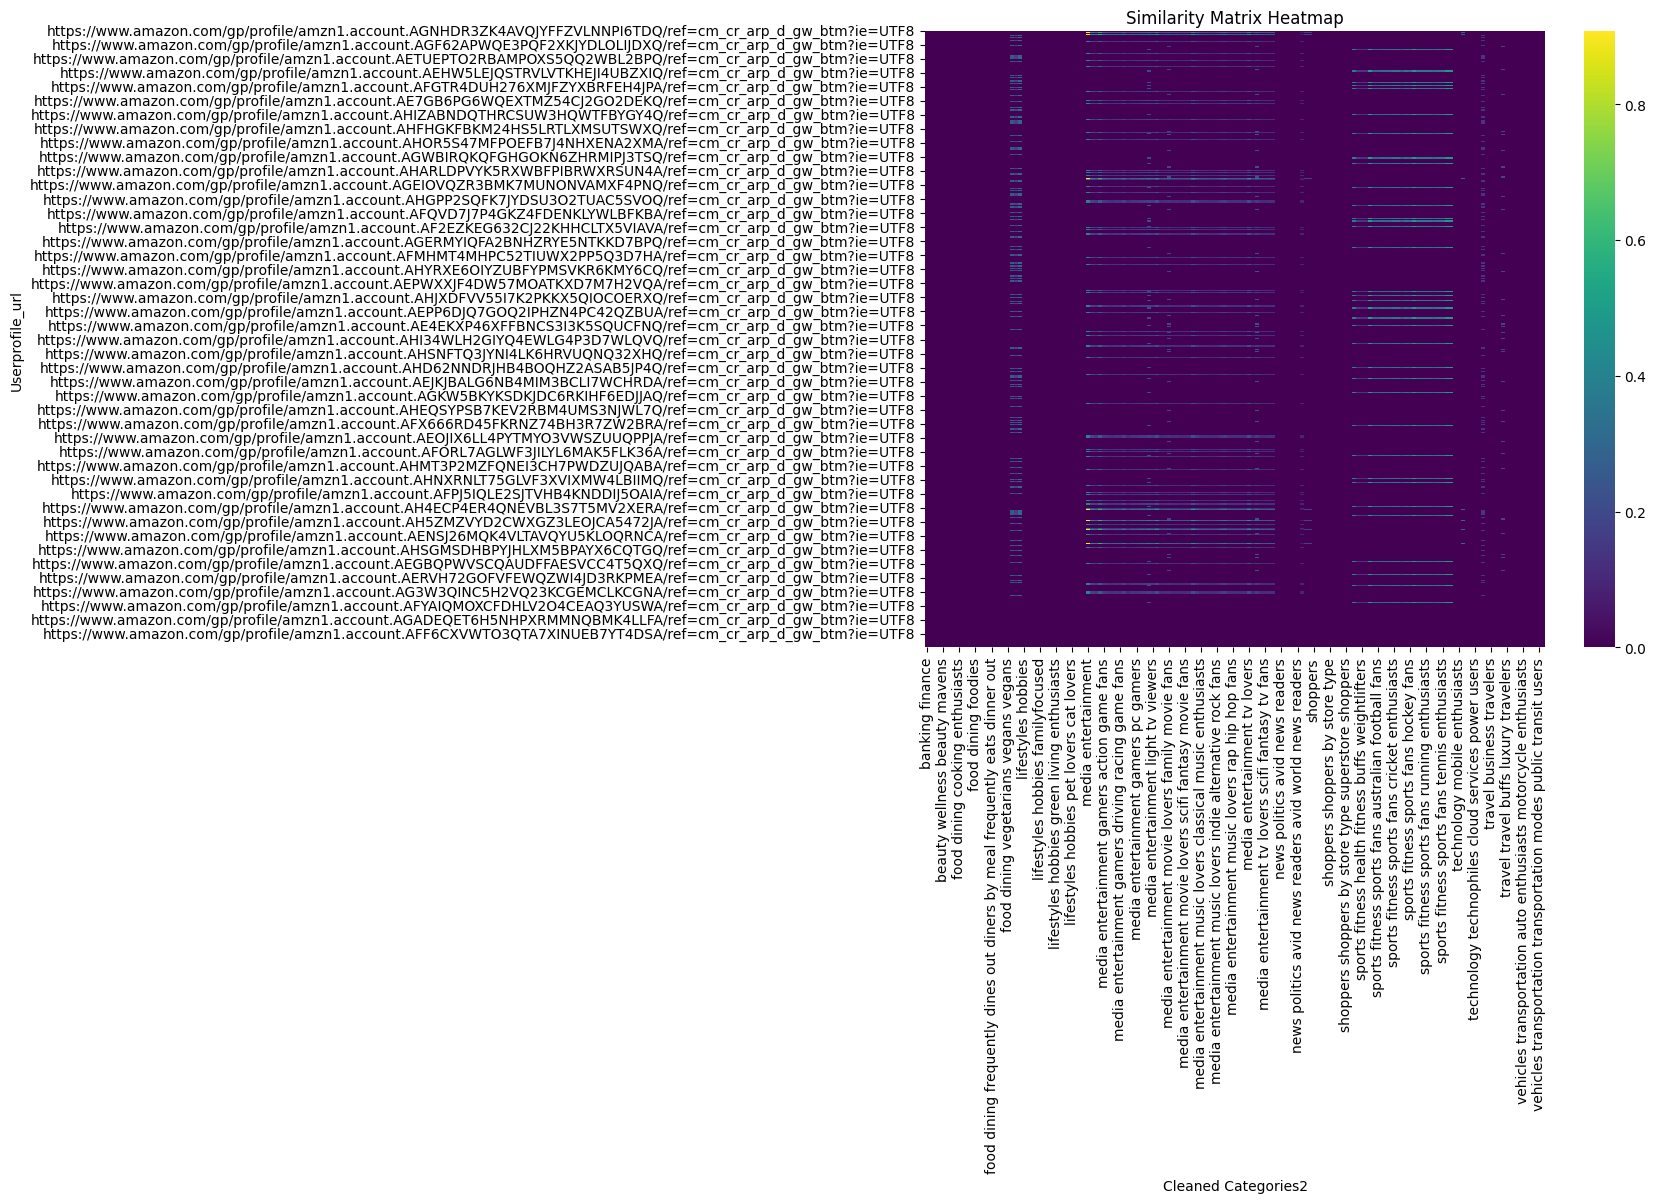

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='viridis')
plt.title("Similarity Matrix Heatmap")
plt.show()

In [18]:
# Remove columns and rows with similarity below 0,2 (done but not working). Print resut (not done)
similarity_df2 = similarity_df.copy()
similarity_df2[similarity_df2 < 0.2] = np.nan

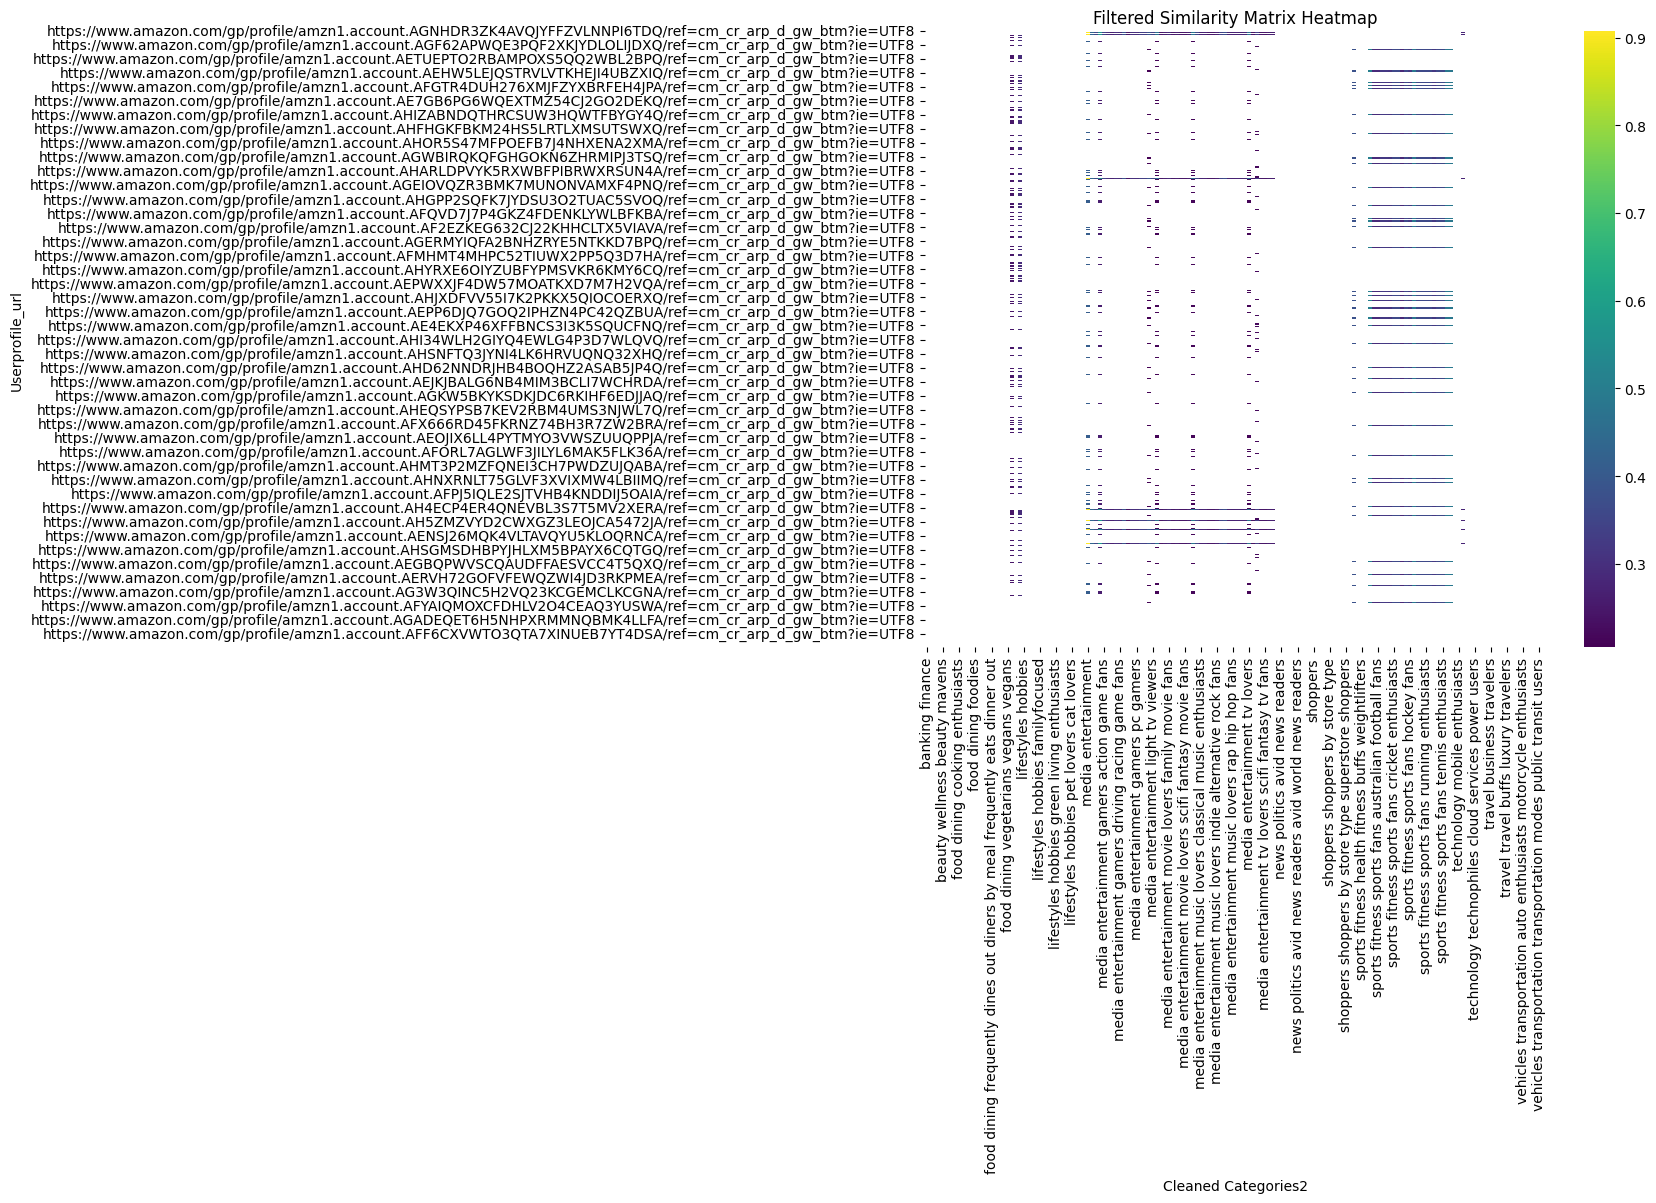

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df2, cmap='viridis')
plt.title("Filtered Similarity Matrix Heatmap")
plt.show()

In [20]:
similarity_df.shape

(10072, 154)

In [21]:
df_combined = pd.concat([df_website.reset_index(drop=True), similarity_df.reset_index(drop=True)], axis=1)

In [22]:
df_combined.shape

(10072, 167)

In [23]:
df_combined.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10072 entries, 0 to 10071
Data columns (total 167 columns):
 #    Column                                                                           Non-Null Count  Dtype  
---   ------                                                                           --------------  -----  
 0    Userprofile_url                                                                  10072 non-null  object 
 1    Username                                                                         10072 non-null  object 
 2    Reviewdate                                                                       10072 non-null  object 
 3    Productname                                                                      10072 non-null  object 
 4    review_title                                                                     10072 non-null  object 
 5    review_text                                                                      10072 non-null  object 
 6

In [24]:
df_combined_numberic = df_combined.iloc[:, [0]+list(range(13, df_combined.shape[1]))]

In [25]:
# How many users there are in google category with similarity above 0,2. Persence =1. Non Presence =0
df_combined_numberic = df_combined_numberic.groupby(["Userprofile_url"]).max().map(lambda x: 1 if x > 0.2 else 0)

In [26]:
df_combined_numberic.head()

,banking finance,banking finance avid investors,banking finance banks online,beauty wellness,beauty wellness beauty mavens,beauty wellness frequently visits salons,food dining,food dining coffee shop regulars,food dining cooking enthusiasts,food dining cooking enthusiasts 30 minute chefs,...,travel travel buffs luxury travelers,travel travel buffs snowbound travelers,vehicles transportation,vehicles transportation auto enthusiasts,vehicles transportation auto enthusiasts motorcycle enthusiasts,vehicles transportation auto enthusiasts performance luxury vehicle enthusiasts,vehicles transportation auto enthusiasts truck suv enthusiasts,vehicles transportation transportation modes,vehicles transportation transportation modes public transit users,vehicles transportation transportation modes taxi service users
Userprofile_url,,,,,,,,,,,,,,,,,,,,,
https://www.amazon.com/gp/profile/amzn1.account.AE2ERWB5QOTTPUAJQ4BK6D55H4WA/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.amazon.com/gp/profile/amzn1.account.AE2GI5TPWCRHLZMEAUKBD4NG4SGQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.amazon.com/gp/profile/amzn1.account.AE2HSZHFWOIFPPSIK44EOIKCSYGA/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.amazon.com/gp/profile/amzn1.account.AE2L3ARXHDZ3IQUCYQTKSBML7EXA/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://www.amazon.com/gp/profile/amzn1.account.AE2M76V4QSF6XZH6EUB5CKV77SFA/ref=cm_cr_arp_d_gw_btm?ie=UTF8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_combined_numberic.shape

(1904, 154)

In [28]:
df_combined_numberic.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
banking finance,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
banking finance avid investors,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
banking finance banks online,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
beauty wellness,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
beauty wellness beauty mavens,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
vehicles transportation auto enthusiasts performance luxury vehicle enthusiasts,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vehicles transportation auto enthusiasts truck suv enthusiasts,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vehicles transportation transportation modes,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vehicles transportation transportation modes public transit users,1904.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
import json

# Reading from a JSON file
with open('../3_Summary_Stat/cluster.json', 'r') as json_file:
    data = json.load(json_file)

print(data)


{'4': ['https://www.amazon.com/gp/profile/amzn1.account.AGNHDR3ZK4AVQJYFFZVLNNPI6TDQ/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AFFWEPJYSOGCZ7OZNZMVLJNXDL7Q/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AFFWEPJYSOGCZ7OZNZMVLJNXDL7Q/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AF23C6LY5QSXP4ZMUSR2CUIAYR4Q/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AFWLWJARS5EHNPGWB6SSS7H3NCJA/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AHUAXP7DAPXVFXA26SBAJBI435LA/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AGKRIR6YVXDMFID4L5QOG4YBX7XA/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AEYAYWBB4A7UU23BFXK7XNED3K7A/ref=cm_cr_arp_d_gw_btm?ie=UTF8', 'https://www.amazon.com/gp/profile/amzn1.account.AGBJLCHM3QH7WLAX74EKRF4QNLAA/ref=cm_cr_arp_d_gw_btm?ie=U

In [30]:
data_mod = {}
for key, value in data.items():
    data_mod[f"Cluster {key}"] = len(value)
    
data_mod

{'Cluster 4': 133,
 'Cluster 2': 263,
 'Cluster 3': 194,
 'Cluster 7': 153,
 'Cluster 0': 145,
 'Cluster 5': 136,
 'Cluster 1': 234,
 'Cluster 6': 172}

In [31]:
cluster_df = pd.DataFrame(list(data_mod.items()), columns=['Cluster', 'Total Unique URL users'])
cluster_df

,Cluster,Total Unique URL users
0,Cluster 4,133
1,Cluster 2,263
2,Cluster 3,194
3,Cluster 7,153
4,Cluster 0,145
5,Cluster 5,136
6,Cluster 1,234
7,Cluster 6,172


In [32]:
sorted_cluster_df = cluster_df.sort_values(by='Cluster', ignore_index=True)
sorted_cluster_df

,Cluster,Total Unique URL users
0,Cluster 0,145
1,Cluster 1,234
2,Cluster 2,263
3,Cluster 3,194
4,Cluster 4,133
5,Cluster 5,136
6,Cluster 6,172
7,Cluster 7,153


In [33]:
count_dict = {}
for key, value in data.items():
    user_count = 0
    for user in value:
        user_sum = df_combined_numberic[df_combined_numberic.index == user].sum(axis=1)
        if (user_sum > 1).any():  # assuming you want to check if any element is > 1
            user_count +=1
    count_dict[f"Cluster {key}"] = user_count
print(count_dict)

{'Cluster 4': 124, 'Cluster 2': 238, 'Cluster 3': 179, 'Cluster 7': 137, 'Cluster 0': 134, 'Cluster 5': 128, 'Cluster 1': 210, 'Cluster 6': 150}


In [34]:
cluster_df2 = pd.DataFrame(list(count_dict.items()), columns=['Cluster', 'Total Unique URL users with affinity']).sort_values(by='Cluster', ignore_index=True)
cluster_df2

,Cluster,Total Unique URL users with affinity
0,Cluster 0,134
1,Cluster 1,210
2,Cluster 2,238
3,Cluster 3,179
4,Cluster 4,124
5,Cluster 5,128
6,Cluster 6,150
7,Cluster 7,137


In [35]:
cluster_df_full = pd.concat([sorted_cluster_df, cluster_df2["Total Unique URL users with affinity"]], axis=1)
cluster_df_full

,Cluster,Total Unique URL users,Total Unique URL users with affinity
0,Cluster 0,145,134
1,Cluster 1,234,210
2,Cluster 2,263,238
3,Cluster 3,194,179
4,Cluster 4,133,124
5,Cluster 5,136,128
6,Cluster 6,172,150
7,Cluster 7,153,137


In [36]:
df_combined_numberic[df_combined_numberic.index == 'https://www.amazon.com/gp/profile/amzn1.account.AE2ERWB5QOTTPUAJQ4BK6D55H4WA/ref=cm_cr_arp_d_gw_btm?ie=UTF8'].columns

Index(['banking finance', 'banking finance avid investors',
       'banking finance banks online', 'beauty wellness',
       'beauty wellness beauty mavens',
       'beauty wellness frequently visits salons', 'food dining',
       'food dining coffee shop regulars', 'food dining cooking enthusiasts',
       'food dining cooking enthusiasts 30 minute chefs',
       ...
       'travel travel buffs luxury travelers',
       'travel travel buffs snowbound travelers', 'vehicles transportation',
       'vehicles transportation auto enthusiasts',
       'vehicles transportation auto enthusiasts motorcycle enthusiasts',
       'vehicles transportation auto enthusiasts performance luxury vehicle enthusiasts',
       'vehicles transportation auto enthusiasts truck suv enthusiasts',
       'vehicles transportation transportation modes',
       'vehicles transportation transportation modes public transit users',
       'vehicles transportation transportation modes taxi service users'],
      dtype

In [37]:
def get_activities(x):
    x = str(x)
    activities = ""
    for category, keywords in lifestyle_dictionary.items():
        if any(keyword in x for keyword in keywords):
            activities += f"{category}_"
    if len(activities) == 0:
        return np.nan
    return activities

In [38]:
df_website["Activities_Cat2"] = df_website['categoryfirst_breadcrumb'].apply(get_activities)

In [39]:
count_dict = {}
for key, value in data.items():
    user_count = set()
    for user in value:
        user_sum = df_combined_numberic[df_combined_numberic.index == user]
        user_sum = user_sum.loc[:, (user_sum != 0).any(axis=0)]
        # if (user_sum > 1).any():  # assuming you want to check if any element is > 1
        user_count.update(df_website[df_website["Userprofile_url"] == user_sum.index[0]]["Activities_Cat2"].values[0].strip().split("_"))
        user_count.remove("")
    count_dict[f"Cluster {key}"] = user_count
print(count_dict)

{'Cluster 4': {'Interests Fashion', 'Interests Home', 'Activities Entertainment', 'Activities Work', 'Interests Job', 'Activities Sports', 'Interests Pets', 'Interests Family', 'Interests Recreation'}, 'Cluster 2': {'Interests Fashion', 'Interests Home', 'Activities Entertainment', 'Interests Media', 'Activities Work', 'Interests Job', 'Activities Sports', 'Interests Pets', 'Interests Family', 'Interests Recreation'}, 'Cluster 3': {'Interests Fashion', 'Interests Home', 'Activities Entertainment', 'Interests Media', 'Activities Work', 'Interests Job', 'Activities Sports', 'Interests Pets', 'Interests Family', 'Interests Recreation'}, 'Cluster 7': {'Interests Fashion', 'Interests Home', 'Activities Entertainment', 'Activities Work', 'Interests Job', 'Activities Sports', 'Interests Pets', 'Interests Family', 'Interests Recreation'}, 'Cluster 0': {'Interests Fashion', 'Interests Home', 'Activities Entertainment', 'Activities Work', 'Interests Job', 'Activities Sports', 'Interests Pets', '

In [40]:
dict_cluster = {"Cluster": [],
               "Interest": []}

for key, value in count_dict.items():
    # for interest in list(value):
    dict_cluster["Cluster"].append(key)
    dict_cluster["Interest"].append(value)

In [41]:
df_cluster_new = pd.DataFrame(dict_cluster).sort_values(by="Cluster", ignore_index=True)
df_cluster_new

,Cluster,Interest
0,Cluster 0,"{Interests Fashion, Interests Home, Activities..."
1,Cluster 1,"{Interests Fashion, Interests Home, Activities..."
2,Cluster 2,"{Interests Fashion, Interests Home, Activities..."
3,Cluster 3,"{Interests Fashion, Interests Home, Activities..."
4,Cluster 4,"{Interests Fashion, Interests Home, Activities..."
5,Cluster 5,"{Interests Fashion, Interests Home, Activities..."
6,Cluster 6,"{Interests Fashion, Interests Home, Activities..."
7,Cluster 7,"{Interests Fashion, Interests Home, Activities..."
